# Clustering On Happiness Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import sys
import subprocess
import os

# Check and install required packages
def install_required_packages():
    required_packages = ['pandas', 'numpy', 'scikit-learn', 'matplotlib', 'seaborn', 'xlrd', 'openpyxl']
    
    for package in required_packages:
        try:
            __import__(package)
            print(f"{package} is already installed.")
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"{package} has been installed.")

def load_and_clean_data(file_path, sheet_name='Happiness'):
    """
    Load happiness data from an Excel file and clean it for analysis.
    Skips header rows and footer information.
    """
    # Check file existence
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Excel file not found: {file_path}")
    
    # Load the Excel file
    print(f"Loading data from {file_path}, sheet: {sheet_name or 'default'}...")
    
    # Try different engines and sheet names to find the right one
    excel_engines = ['xlrd', 'openpyxl']
    possible_sheet_names = [sheet_name, 'Happiness']  
    
    df_raw = None
    used_engine = None
    used_sheet = None
    
    for engine in excel_engines:
        for sheet in possible_sheet_names:
            try:
                print(f"Attempting to read with engine: {engine}, sheet: {sheet or 'default'}")
                df_raw = pd.read_excel(file_path, sheet_name=sheet, engine=engine)
                used_engine = engine
                used_sheet = sheet
                print(f"Successfully loaded data with {engine}, sheet: {sheet or 'default'}")
                break
            except Exception as e:
                print(f"  Failed with error: {str(e)}")
        
        if df_raw is not None:
            break
    
    if df_raw is None:
        raise Exception("Could not read the Excel file with any combination of engines and sheet names.")
    
    print(f"Successfully loaded data using {used_engine} engine and sheet '{used_sheet or 'default'}'")
    print("Initial data shape:", df_raw.shape)
    
    # Display column names for debugging
    print("\nFirst few column names:")
    for i, col in enumerate(df_raw.columns[:10]):
        print(f"{i}: {col}")
    
    # Display a sample of the raw data for debugging
    print("\nSample of raw data (first 5 rows):")
    print(df_raw.head().to_string())
    
    first_col = df_raw.columns[0]
    header_detected = not (isinstance(first_col, int) or pd.isna(first_col) or 
                         'unnamed' in str(first_col).lower() or str(first_col) == '0')
    
    if not header_detected:
        # Look for the actual data section by finding rows with likely headers
        header_row = None
        for i in range(min(20, len(df_raw))):  # Check first 20 rows
            row = df_raw.iloc[i]
            row_str = ' '.join(str(x).lower() for x in row.values)
            # Look for rows containing likely header text
            if any(term in row_str for term in ['low', 'medium', 'high', 'average', 'rating', 'confidence', 'per cent']):
                header_row = i
                print(f"Detected header at row {i}")
                break
        
        # If no header found, default to row 3 
        if header_row is None:
            header_row = 3
            print(f"Using default header row: {header_row}")
        
        # Re-read the file with the identified header row
        try:
            df_raw = pd.read_excel(file_path, sheet_name=used_sheet, header=header_row, engine=used_engine)
            print("Re-read the data with header row:", header_row)
        except Exception as e:
            print(f"Error re-reading with header: {e}")
            # If re-reading fails, try to manually set the header from the existing dataframe
            df_raw = df_raw.copy()
            df_raw.columns = df_raw.iloc[header_row]
            df_raw = df_raw.iloc[header_row+1:].reset_index(drop=True)
            print("Manually set header from existing dataframe")

    # Clean up column names
    df = df_raw.copy()
    df.columns = [str(col).strip() for col in df.columns]
    
    # Check the first column name and rename if needed
    first_col = df.columns[0]
    if first_col == '0' or first_col == 0 or pd.isna(first_col) or 'unnamed' in str(first_col).lower():
        df = df.rename(columns={first_col: 'Region'})
        first_col = 'Region'
    
    df = df.dropna(subset=[first_col])
    df = df[~df[first_col].astype(str).str.contains('UK|country|region|UA|LA|LGD', case=False)]
    
    
    non_data_rows = []
    for idx, row in df.iterrows():
        if pd.notna(row[first_col]) and sum(pd.isna(row[1:])) > len(row) * 0.8:
            non_data_rows.append(idx)
    
    if non_data_rows:
        print(f"Removing {len(non_data_rows)} non-data rows")
        df = df.drop(non_data_rows)
    
    # Display column information
    print("\nColumns in the dataset:")
    for i, col in enumerate(df.columns):
        print(f"{i}: {col}")
    
    # Look for the happiness rating column
    happiness_cols = []
    for col in df.columns:
        col_str = str(col).lower()
        if any(term in col_str for term in ['average', 'rating', 'happiness', 'mean']):
            happiness_cols.append(col)
    
    if not happiness_cols:
        print("No obvious happiness column found, looking for numeric columns...")
        for i, col in enumerate(df.columns[1:10]):  # Check first few numeric columns
            try:
                numeric_values = pd.to_numeric(df[col], errors='coerce')
                if not numeric_values.isna().all():
                    mean_val = numeric_values.mean()
                    if 0 < mean_val < 10: 
                        happiness_cols.append(col)
                        print(f"Potential happiness column found: {col} (mean: {mean_val:.2f})")
            except:
                continue
    
    # Find category columns (Low, Medium, High, Very High)
    category_cols = []
    for col in df.columns:
        col_lower = str(col).lower()
        if any(term in col_lower for term in ['low', 'medium', 'high', 'per cent']):
            category_cols.append(col)
    
    if happiness_cols and category_cols:
        columns_to_keep = [first_col] + happiness_cols + category_cols
        print(f"Selected {len(columns_to_keep)} columns based on column names")
    else:
        print("Using default column positions based on screenshot...")

        avg_rating_col = df.columns[min(6, len(df.columns)-1)]  
        category_cols = df.columns[1:min(5, len(df.columns))]  
        columns_to_keep = [first_col, avg_rating_col] + list(category_cols)
        print(f"Selected {len(columns_to_keep)} columns based on default positions")
    
    # Keep only the selected columns
    print(f"\nSelected columns: {columns_to_keep}")
    try:
        df_clean = df[columns_to_keep].copy()
    except KeyError as e:
        print(f"KeyError: {e}. Using available columns instead.")
        df_clean = df.copy()
    
    # Rename columns for clarity
    df_clean = df_clean.rename(columns={first_col: 'Region'})
    
    for col in df_clean.columns[1:]: 
        df_clean[col] = df_clean[col].replace(['x', '-', '*', '..'], np.nan)
        try:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        except:
            print(f"Warning: Could not convert column {col} to numeric")
    
    # Drop rows with too many missing values (more than 50%)
    threshold = len(df_clean.columns) // 2
    before_drop = len(df_clean)
    df_clean = df_clean.dropna(thresh=threshold)
    print(f"Dropped {before_drop - len(df_clean)} rows with too many missing values")
    
    if len(df_clean) == 0:
        raise ValueError("No data remains after cleaning. Check your Excel file and column selection.")
    
    print(f"\nCleaned data: {df_clean.shape[0]} regions with {df_clean.shape[1]} features")
    print(df_clean.head().to_string())
    
    # Save the cleaned data to CSV for inspection
    df_clean.to_csv('cleaned_happiness_data.csv', index=False)
    print("Saved cleaned data to 'cleaned_happiness_data.csv'")
    
    return df_clean

def preprocess_for_clustering(df):
    """
    Preprocess the cleaned data for clustering:
    - Handle missing values
    - Scale the features
    - Return the processed data and the scaler
    """
    # Make a copy of the dataframe
    df_prep = df.copy()
    
    # Set region as index for easier tracking
    regions = df_prep['Region'].values
    df_prep = df_prep.set_index('Region')
    
    # Check for missing values
    missing_count = df_prep.isna().sum()
    if missing_count.sum() > 0:
        print("\nMissing values per column:")
        print(missing_count)
    
    # Handle missing values (fill with column median)
    df_prep = df_prep.fillna(df_prep.median())
    
    # Verify no missing values remain
    if df_prep.isna().sum().sum() > 0:
        df_prep = df_prep.dropna(axis=1, how='all')
        df_prep = df_prep.fillna(0)
        print("Filled remaining missing values with 0")
    
    # Print statistics before scaling
    print("\nFeature statistics before scaling:")
    print(df_prep.describe().round(2))
    
    # Standardize the features (important for k-means)
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_prep),
        index=df_prep.index,
        columns=df_prep.columns
    )
    
    print("\nFeature statistics after scaling:")
    print(df_scaled.describe().round(2))
    
    print("Data preprocessing complete.")
    return df_scaled, scaler, regions

def determine_optimal_clusters(df_scaled, max_clusters=10):
    """
    Determine the optimal number of clusters using:
    1. Elbow method
    2. Silhouette score
    """
    # Calculate inertia (for elbow method) and silhouette scores
    inertia_values = []
    silhouette_values = []
    
    max_possible_clusters = min(max_clusters, len(df_scaled) - 1, 10)
    
    for k in range(2, max_possible_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df_scaled)
        inertia_values.append(kmeans.inertia_)
        
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(df_scaled, labels)
        silhouette_values.append(silhouette_avg)
        print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")
    
    # Plot elbow method
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_possible_clusters + 1), inertia_values, 'bo-')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    
    # Plot silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_possible_clusters + 1), silhouette_values, 'ro-')
    plt.title('Silhouette Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('optimal_clusters.png')
    plt.close()
    
    # Find optimal k from silhouette scores
    optimal_k = np.argmax(silhouette_values) + 2  
    
    print(f"Optimal number of clusters suggested: {optimal_k}")
    return optimal_k

def perform_clustering(df_scaled, optimal_k):
    """
    Perform k-means clustering with the optimal number of clusters.
    """
    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    
    # Add cluster labels to the original dataframe
    df_with_clusters = df_scaled.copy()
    df_with_clusters['Cluster'] = cluster_labels
    
    # Count regions per cluster
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    print("\nNumber of regions in each cluster:")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} regions")
    
    print(f"Clustering complete with {optimal_k} clusters.")
    return df_with_clusters, kmeans.cluster_centers_

def visualize_clusters(df_with_clusters, cluster_centers, regions):
    """
    Visualize the clusters using PCA for dimensionality reduction.
    """
    # Apply PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    
    # Check if we have enough features for PCA
    if df_with_clusters.drop('Cluster', axis=1).shape[1] < 2:
        print("Not enough features for PCA. Using original features for visualization.")
        # Use the original features instead of PCA
        feature_cols = df_with_clusters.columns.drop('Cluster')
        df_viz = pd.DataFrame({
            'Region': regions,
            'Feature1': df_with_clusters[feature_cols[0]],
            'Feature2': df_with_clusters[feature_cols[1]] if len(feature_cols) > 1 else np.zeros(len(regions)),
            'Cluster': df_with_clusters['Cluster']
        })
        x_col, y_col = 'Feature1', 'Feature2'
    else:
        # Proceed with PCA
        feature_data = df_with_clusters.drop('Cluster', axis=1)
        reduced_data = pca.fit_transform(feature_data)
        
        # Create a dataframe with the reduced dimensions
        df_viz = pd.DataFrame({
            'Region': regions,
            'PCA1': reduced_data[:, 0],
            'PCA2': reduced_data[:, 1],
            'Cluster': df_with_clusters['Cluster']
        })
        x_col, y_col = 'PCA1', 'PCA2'
        
        # Print explained variance
        explained_variance = pca.explained_variance_ratio_
        print(f"\nPCA explained variance: {explained_variance[0]:.2f}, {explained_variance[1]:.2f}")
        print(f"Total explained variance: {sum(explained_variance):.2f}")
    
    # Plot the clusters
    plt.figure(figsize=(14, 10))
    
    # Create a color palette
    palette = sns.color_palette("husl", df_with_clusters['Cluster'].nunique())
    
    # Plot each cluster
    scatter = sns.scatterplot(
        x=x_col, y=y_col, 
        hue='Cluster', 
        palette=palette,
        s=100, 
        data=df_viz
    )
    
    # Add region labels (limit to prevent overcrowding)
    # Select a subset of points to label to avoid overcrowding
    n_regions = len(regions)
    if n_regions > 50:
        # Label only a sample of points (every nth point)
        step = max(1, n_regions // 50)
        label_indices = range(0, n_regions, step)
    else:
        label_indices = range(n_regions)
    
    for i in label_indices:
        row = df_viz.iloc[i]
        plt.annotate(
            row['Region'],
            (row[x_col], row[y_col]),
            fontsize=8,
            alpha=0.7,
            ha='center',
            va='bottom',
            xytext=(0, 5),  # Add small vertical offset
            textcoords='offset points'
        )
    
    # Plot cluster centers if using PCA
    if x_col == 'PCA1':
        centers_reduced = pca.transform(cluster_centers)
        plt.scatter(
            centers_reduced[:, 0], centers_reduced[:, 1],
            s=200,
            marker='X',
            c=range(len(centers_reduced)),
            cmap='autumn_r',
            edgecolors='k',
            linewidths=2
        )
    else:
        # Plot cluster centers in original feature space
        plt.scatter(
            [center[0] for center in cluster_centers],
            [center[1] for center in cluster_centers],
            s=200,
            marker='X',
            c=range(len(cluster_centers)),
            cmap='autumn_r',
            edgecolors='k',
            linewidths=2
        )
    
    plt.title('Cluster Visualization', fontsize=15)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.legend(title='Cluster')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('happiness_clusters.png', dpi=300)
    plt.close()
    
    print("Cluster visualization saved as 'happiness_clusters.png'.")
    
    return df_viz

def analyze_clusters(df_clean, df_with_clusters, cluster_centers, scaler):
    """
    Analyze the characteristics of each cluster.
    """
    # Get original features (non-scaled)
    df_orig = df_clean.copy().set_index('Region')
    
    # Add cluster assignments to original data
    region_indices = df_with_clusters.index
    df_orig.loc[region_indices, 'Cluster'] = df_with_clusters['Cluster'].values
    
    # Calculate cluster statistics
    print("\nCluster Statistics:")
    for cluster in sorted(df_orig['Cluster'].unique()):
        cluster_data = df_orig[df_orig['Cluster'] == cluster]
        
        print(f"\nCluster {cluster} ({len(cluster_data)} regions):")
        print("Example regions:", ", ".join(cluster_data.index.tolist()[:5]))
        
        # Display mean values for each feature in this cluster
        print("Mean values:")
        for col in cluster_data.columns[:-1]:  # Exclude 'Cluster' column
            cluster_mean = cluster_data[col].mean()
            overall_mean = df_orig[col].mean()
            diff = cluster_mean - overall_mean
            print(f"  {col}: {cluster_mean:.2f} (overall: {overall_mean:.2f}, diff: {diff:+.2f})")
    
    # Inverse transform the cluster centers to original scale
    orig_centers = pd.DataFrame(
        scaler.inverse_transform(cluster_centers),
        columns=df_with_clusters.columns[:-1]
    )
    
    print("\nCluster Centers (original scale):")
    print(orig_centers.round(2))
    
    # Create cluster summary
    cluster_summary = []
    for i in range(len(orig_centers)):
        # Find regions in this cluster
        regions_in_cluster = df_orig[df_orig['Cluster'] == i].index.tolist()
        
        # Find happiness column (look for average/rating/happiness in column name)
        happiness_cols = [col for col in orig_centers.columns if any(term in str(col).lower() 
                         for term in ['average', 'rating', 'happiness', 'mean'])]
        
        if happiness_cols:
            happiness_col = happiness_cols[0]
        else:
            # If no specific column found, use the first numeric column
            happiness_col = orig_centers.columns[0]
        
        # Determine happiness level
        avg_happiness = orig_centers.loc[i, happiness_col]
        print("avg happiness is  ",avg_happiness)
        if avg_happiness > 40.0:
            happiness_level = "high happiness"
        elif avg_happiness < 40.0:
            happiness_level = "medium happiness"
        else:
            happiness_level = "lower happiness"
        
        # Prepare cluster characteristics
        characteristics = {
            'Cluster': i,
            'Number of Regions': len(regions_in_cluster),
            'Example Regions': ', '.join(regions_in_cluster[:5]) + ('...' if len(regions_in_cluster) > 5 else ''),
            'Avg Happiness': avg_happiness,
            'Characteristics': f"Cluster with {happiness_level}"
        }
        
        cluster_summary.append(characteristics)
    
    # Create cluster summary as DataFrame
    cluster_summary_df = pd.DataFrame(cluster_summary)
    
    # Save cluster analysis to CSV
    cluster_summary_df.to_csv('cluster_summary.csv', index=False)
    print("\nCluster summary saved to 'cluster_summary.csv'")
    
    # Save detailed cluster data
    df_orig.to_csv('cluster_details.csv')
    print("Complete cluster details saved to 'cluster_details.csv'")
    
    return cluster_summary_df

def generate_detailed_cluster_description(df_clean, df_with_clusters, cluster_centers, scaler):
    """
    Generate detailed descriptions of what makes each cluster distinct.
    """
    # Get original features with cluster assignments
    df_orig = df_clean.copy().set_index('Region')
    region_indices = df_with_clusters.index
    df_orig.loc[region_indices, 'Cluster'] = df_with_clusters['Cluster'].values
    
    # Calculate cluster statistics for each feature
    cluster_stats = []
    overall_mean = df_orig.drop('Cluster', axis=1).mean()
    overall_std = df_orig.drop('Cluster', axis=1).std()
    
    # Identify key features
    happiness_cols = [col for col in df_orig.columns if any(term in str(col).lower() 
                     for term in ['average', 'rating', 'happiness', 'mean'])]
    
    if not happiness_cols:
        # If no happiness column found, use the first numeric column
        numeric_cols = [col for col in df_orig.columns 
                       if col != 'Cluster' and pd.api.types.is_numeric_dtype(df_orig[col])]
        if numeric_cols:
            happiness_cols = [numeric_cols[0]]
    
    for cluster in sorted(df_orig['Cluster'].unique()):
        cluster_data = df_orig[df_orig['Cluster'] == cluster]
        regions = cluster_data.index.tolist()
        
        # Calculate key statistics
        stats = {
            'Cluster': cluster,
            'Size': len(regions),
            'Example Regions': ', '.join(regions[:5]) + ('...' if len(regions) > 5 else ''),
        }
        
        # Calculate distinctive features (those that differ most from overall mean)
        feature_diff = {}
        for col in df_orig.columns:
            if col != 'Cluster' and pd.api.types.is_numeric_dtype(df_orig[col]):
                mean_diff = cluster_data[col].mean() - overall_mean[col]
                if overall_std[col] > 0:  # Avoid division by zero
                    std_diff = mean_diff / overall_std[col]
                    feature_diff[col] = (mean_diff, std_diff)
        
        # Sort by absolute standardized difference
        sorted_features = sorted(feature_diff.items(), key=lambda x: abs(x[1][1]), reverse=True)
        
        # Add most distinctive features
        for i, (feature, (mean_diff, std_diff)) in enumerate(sorted_features[:5]):
            direction = "higher" if mean_diff > 0 else "lower"
            stats[f'Distinctive Feature {i+1}'] = f"{feature}: {abs(mean_diff):.2f} {direction} than average ({abs(std_diff):.2f} std)"
        
        # Add happiness assessment if available
        if happiness_cols:
            happiness_col = happiness_cols[0]
            avg_happiness = cluster_data[happiness_col].mean()
            overall_happiness = overall_mean[happiness_col]
            
            if avg_happiness > overall_happiness + 0.2 * overall_std[happiness_col]:
                happiness_level = "Above average happiness"
            elif avg_happiness < overall_happiness - 0.2 * overall_std[happiness_col]:
                happiness_level = "Below average happiness"
            else:
                happiness_level = "Average happiness"
                
            stats['Happiness Assessment'] = f"{happiness_level} (Mean: {avg_happiness:.2f}, Overall: {overall_happiness:.2f})"
        
        cluster_stats.append(stats)
    
    # Create detailed description DataFrame
    descriptions_df = pd.DataFrame(cluster_stats)
    
    # Save to CSV
    descriptions_df.to_csv('detailed_cluster_descriptions.csv', index=False)
    print("Detailed cluster descriptions saved to 'detailed_cluster_descriptions.csv'")
    
    # Generate readable text descriptions
    print("\nCLUSTER INTERPRETATIONS:")
    print("========================")
    
    for cluster in sorted(df_orig['Cluster'].unique()):
        cluster_info = descriptions_df[descriptions_df['Cluster'] == cluster].iloc[0]
        
        print(f"\nCLUSTER {cluster}:")
        print(f"Number of regions: {cluster_info['Size']}")
        print(f"Example regions: {cluster_info['Example Regions']}")
        
        if 'Happiness Assessment' in cluster_info:
            print(f"Happiness profile: {cluster_info['Happiness Assessment']}")
        
        print("Distinctive characteristics:")
        for i in range(1, 6):
            feature_key = f'Distinctive Feature {i}'
            if feature_key in cluster_info:
                print(f"  - {cluster_info[feature_key]}")
    
    return descriptions_df

def enhance_cluster_visualization(df_with_clusters, cluster_centers, regions, scaler, df_clean):
    """
    Create an enhanced cluster visualization with better labels and descriptions.
    """
    # Apply PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    feature_data = df_with_clusters.drop('Cluster', axis=1)
    reduced_data = pca.fit_transform(feature_data)
    
    # Create dataframe with reduced dimensions
    df_viz = pd.DataFrame({
        'Region': regions,
        'PCA1': reduced_data[:, 0],
        'PCA2': reduced_data[:, 1],
        'Cluster': df_with_clusters['Cluster']
    })
    
    # Get original features for interpreting clusters
    df_orig = df_clean.copy().set_index('Region')
    region_indices = df_with_clusters.index
    df_orig.loc[region_indices, 'Cluster'] = df_with_clusters['Cluster'].values
    
    # Get feature summaries for each cluster for labeling
    cluster_means = df_orig.groupby('Cluster').mean()
    
    # Identify happiness column
    happiness_cols = [col for col in df_orig.columns if any(term in str(col).lower() 
                     for term in ['average', 'rating', 'happiness', 'mean'])]
    
    if happiness_cols:
        happiness_col = happiness_cols[0]
    else:
        numeric_cols = [col for col in df_orig.columns 
                       if col != 'Cluster' and pd.api.types.is_numeric_dtype(df_orig[col])]
        happiness_col = numeric_cols[0] if numeric_cols else None
    
    cluster_labels = {}
    if happiness_col:
        overall_mean = df_orig[happiness_col].mean()
        for cluster in cluster_means.index:
            cluster_happiness = cluster_means.loc[cluster, happiness_col]
            if cluster_happiness > overall_mean:
                label = f"Cluster {cluster}: Higher Happiness (Avg: {cluster_happiness:.2f})"
            else:
                label = f"Cluster {cluster}: Lower Happiness (Avg: {cluster_happiness:.2f})"
            cluster_labels[cluster] = label
    else:
        for cluster in cluster_means.index:
            cluster_labels[cluster] = f"Cluster {cluster}"
    
    # Plot the clusters
    plt.figure(figsize=(14, 10))
    
    # Create a color palette
    palette = sns.color_palette("husl", df_with_clusters['Cluster'].nunique())
    
    # Plot each cluster
    for cluster_num in sorted(df_viz['Cluster'].unique()):
        cluster_data = df_viz[df_viz['Cluster'] == cluster_num]
        plt.scatter(
            cluster_data['PCA1'], 
            cluster_data['PCA2'],
            s=100,
            color=palette[cluster_num],
            label=cluster_labels[cluster_num],
            alpha=0.7
        )
    
    # Label points (limit to prevent overcrowding)
    n_regions = len(regions)
    if n_regions > 30:
        step = max(1, n_regions // 30)
        label_indices = range(0, n_regions, step)
    else:
        label_indices = range(n_regions)
    
    for i in label_indices:
        row = df_viz.iloc[i]
        plt.annotate(
            row['Region'],
            (row['PCA1'], row['PCA2']),
            fontsize=8,
            alpha=0.7,
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points'
        )
    
    # Plot cluster centers
    centers_reduced = pca.transform(cluster_centers)
    plt.scatter(
        centers_reduced[:, 0], centers_reduced[:, 1],
        s=300,
        marker='X',
        c=range(len(centers_reduced)),
        cmap='autumn_r',
        edgecolors='k',
        linewidths=2
    )
    
    # Add PCA explained variance to axis labels
    explained_variance = pca.explained_variance_ratio_
    plt.xlabel(f'PCA1 (Explains {explained_variance[0]:.1%} of variance)', fontsize=12)
    plt.ylabel(f'PCA2 (Explains {explained_variance[1]:.1%} of variance)', fontsize=12)
    
    # Add feature loadings to understand what PCA dimensions represent
    loadings = pca.components_
    feature_names = df_with_clusters.columns[:-1]  # Exclude Cluster column
    
    # Find most important features for PCA1 and PCA2
    pca1_loadings = [(abs(loadings[0][i]), feature_names[i]) for i in range(len(feature_names))]
    pca2_loadings = [(abs(loadings[1][i]), feature_names[i]) for i in range(len(feature_names))]
    pca1_loadings.sort(reverse=True)
    pca2_loadings.sort(reverse=True)
    
    top_pca1 = [f"{name} ({loading:.2f})" for loading, name in pca1_loadings[:3]]
    top_pca2 = [f"{name} ({loading:.2f})" for loading, name in pca2_loadings[:3]]
    

    
    plt.title('Enhanced Cluster Visualization\nRegions Grouped by Happiness Profile', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Make room for the feature loadings text
    plt.savefig('enhanced_happiness_clusters.png', dpi=300)
    plt.show()
    plt.close()
    
    print("Enhanced cluster visualization saved as 'enhanced_happiness_clusters.png'.")
    
    return df_viz
def main():
    """
    Main function to execute the happiness data clustering analysis.
    """
    # Install required packages
    install_required_packages()
    
    file_path = 'geographicbreakdownreferencetable_tcm77-417203.xlsx'
    
    try:

        df_clean = load_and_clean_data(file_path)
        
        # Preprocess the data for clustering
        df_scaled, scaler, regions = preprocess_for_clustering(df_clean)
        
        # Determine the optimal number of clusters
        optimal_k = determine_optimal_clusters(df_scaled)
        
        # Perform clustering
        df_with_clusters, cluster_centers = perform_clustering(df_scaled, optimal_k)
        
        # Generate enhanced visualizations and analyses
        print("\n--- GENERATING ENHANCED CLUSTER ANALYSIS ---")
        
        # Enhanced cluster visualization
        enhance_cluster_visualization(df_with_clusters, cluster_centers, regions, scaler, df_clean)

        
        # Generate detailed cluster descriptions
        detailed_descriptions = generate_detailed_cluster_description(df_clean, df_with_clusters, cluster_centers, scaler)
        
        # Original analysis (kept for backwards compatibility)
        visualize_clusters(df_with_clusters, cluster_centers, regions)
        cluster_summary = analyze_clusters(df_clean, df_with_clusters, cluster_centers, scaler)
        
        print("\nEnhanced analysis complete! Check the output files for detailed results.")
        print(f"The happiness data has been clustered into {optimal_k} distinct groups.")
        
    except Exception as e:
        import traceback
        print(f"An error occurred: {e}")
        print("Error details:")
        traceback.print_exc()
if __name__ == "__main__":
    main()

pandas is already installed.
numpy is already installed.
Installing scikit-learn...
scikit-learn has been installed.
matplotlib is already installed.
seaborn is already installed.
xlrd is already installed.
openpyxl is already installed.
Loading data from geographicbreakdownreferencetable_tcm77-417203.xlsx, sheet: Happiness...
Attempting to read with engine: xlrd, sheet: Happiness
Successfully loaded data with xlrd, sheet: Happiness
Successfully loaded data using xlrd engine and sheet 'Happiness'
Initial data shape: (462, 25)

First few column names:
0: Happiness1 by UK, country, region, UA/ County in England, LADs in England, UAs in Wales, LAs in Scotland, LGDs in Northern Ireland, April 2014 to March 20152,4
1: Unnamed: 1
2: Unnamed: 2
3: Unnamed: 3
4: Unnamed: 4
5: Unnamed: 5
6: Unnamed: 6
7: Unnamed: 7
8: Unnamed: 8
9: Unnamed: 9

Sample of raw data (first 5 rows):
  Happiness1 by UK, country, region, UA/ County in England, LADs in England, UAs in Wales, LAs in Scotland, LGDs in No

C:\Users\Zubair\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Enhanced cluster visualization saved as 'enhanced_happiness_clusters.png'.
Detailed cluster descriptions saved to 'detailed_cluster_descriptions.csv'

CLUSTER INTERPRETATIONS:

CLUSTER 0.0:
Number of regions: 130
Example regions: K02000001, E92000001, E06000048, E06000003, E08000021...
Happiness profile: Above average happiness (Mean: 41.71, Overall: 39.81)
Distinctive characteristics:
  - Unnamed: 4: 1.12 lower than average (0.60 std)
  - Unnamed: 6: 1.90 higher than average (0.56 std)

CLUSTER 1.0:
Number of regions: 84
Example regions: E12000001, E06000047, E06000005, E06000001, E06000002...
Happiness profile: Below average happiness (Mean: 36.86, Overall: 39.81)
Distinctive characteristics:
  - Unnamed: 4: 1.73 higher than average (0.93 std)
  - Unnamed: 6: 2.94 lower than average (0.86 std)

PCA explained variance: 0.81, 0.19
Total explained variance: 1.00


C:\Users\Zubair\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Cluster visualization saved as 'happiness_clusters.png'.

Cluster Statistics:

Cluster 0.0 (130 regions):
Example regions: K02000001, E92000001, E06000048, E06000003, E08000021
Mean values:
  Unnamed: 6: 41.71 (overall: 39.81, diff: +1.90)
  Unnamed: 1: nan (overall: nan, diff: +nan)
  Unnamed: 2: nan (overall: nan, diff: +nan)
  Unnamed: 3: nan (overall: nan, diff: +nan)
  Unnamed: 4: 8.39 (overall: 9.51, diff: -1.12)

Cluster 1.0 (84 regions):
Example regions: E12000001, E06000047, E06000005, E06000001, E06000002
Mean values:
  Unnamed: 6: 36.86 (overall: 39.81, diff: -2.94)
  Unnamed: 1: nan (overall: nan, diff: +nan)
  Unnamed: 2: nan (overall: nan, diff: +nan)
  Unnamed: 3: nan (overall: nan, diff: +nan)
  Unnamed: 4: 11.24 (overall: 9.51, diff: +1.73)

Cluster Centers (original scale):
   Unnamed: 6  Unnamed: 4
0       41.71        8.39
1       36.86       11.24
avg happiness is   41.70892307692308
avg happiness is   36.8625

Cluster summary saved to 'cluster_summary.csv'
Complet

# Corrleation Analysis Between Weather & Happiness Dataset

=== Starting Weather and Happiness Analysis ===

1. Processing weather station data...


C:\Users\Zubair\AppData\Local\Temp\ipykernel_25372\4265635489.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_by_latitude = combined_df_filled.groupby('latitude_band').agg({


Processed weather data by latitude band:
  latitude_band       tmax      tmin        af        rain         sun  \
0         49-51  14.244286  7.170789  2.827813   70.792191  137.168553   
1         51-53  13.893173  6.433625  3.497877   62.373881  124.149014   
2         53-55  12.684205  5.989750  3.277168   68.013420  116.822712   
3         55-57  11.906276  5.390967  3.623372  107.660751  111.163263   
4         57-59  11.051586  4.801219  4.241379   76.772746  108.459623   
5         59-61   9.517138  5.099912  3.107774   96.971466   89.102827   

    latitude  
0  50.753775  
1  51.911482  
2  53.906442  
3  56.022952  
4  57.950817  
5  60.139000  

2. Loading happiness data...
Successfully loaded raw happiness data with shape: (463, 25)
Found 'Area names' at row 5, column 1
Found 'Average (mean) rating' at row 2, column 8
Cleaned happiness data shape: (14, 2)
Sample of cleaned data:
                     region  happiness_score
0            UNITED KINGDOM             7.46
1    

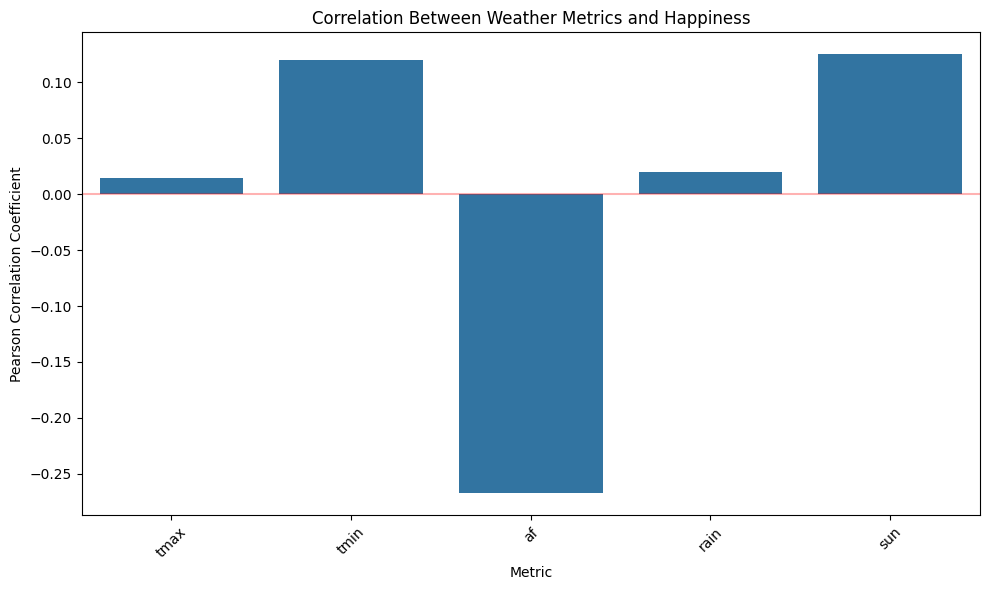

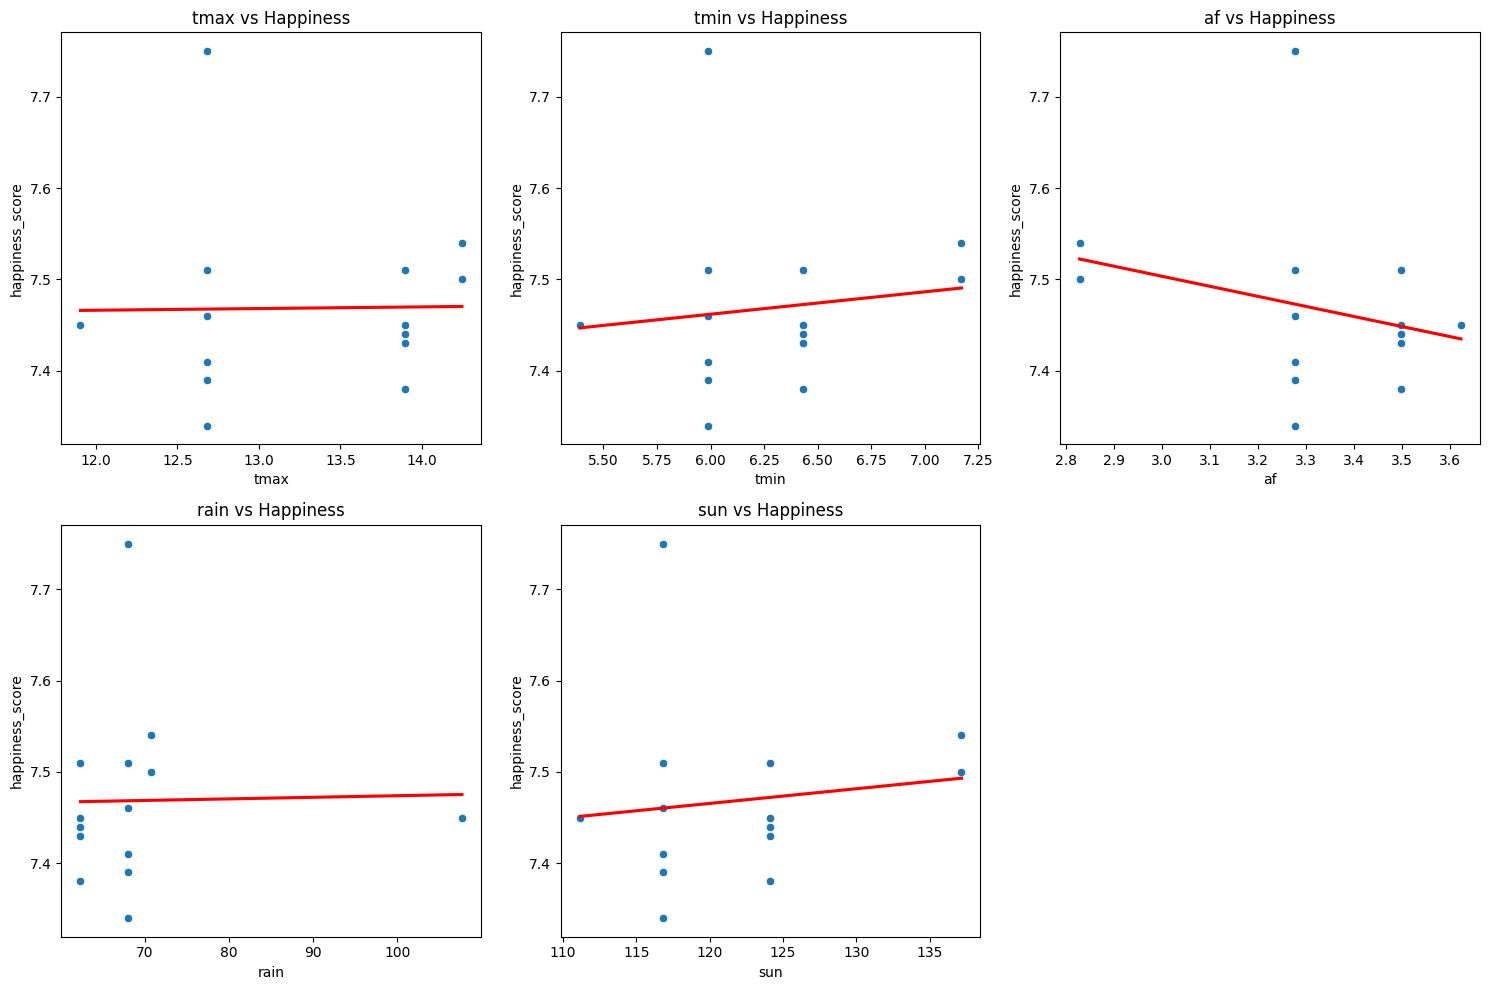

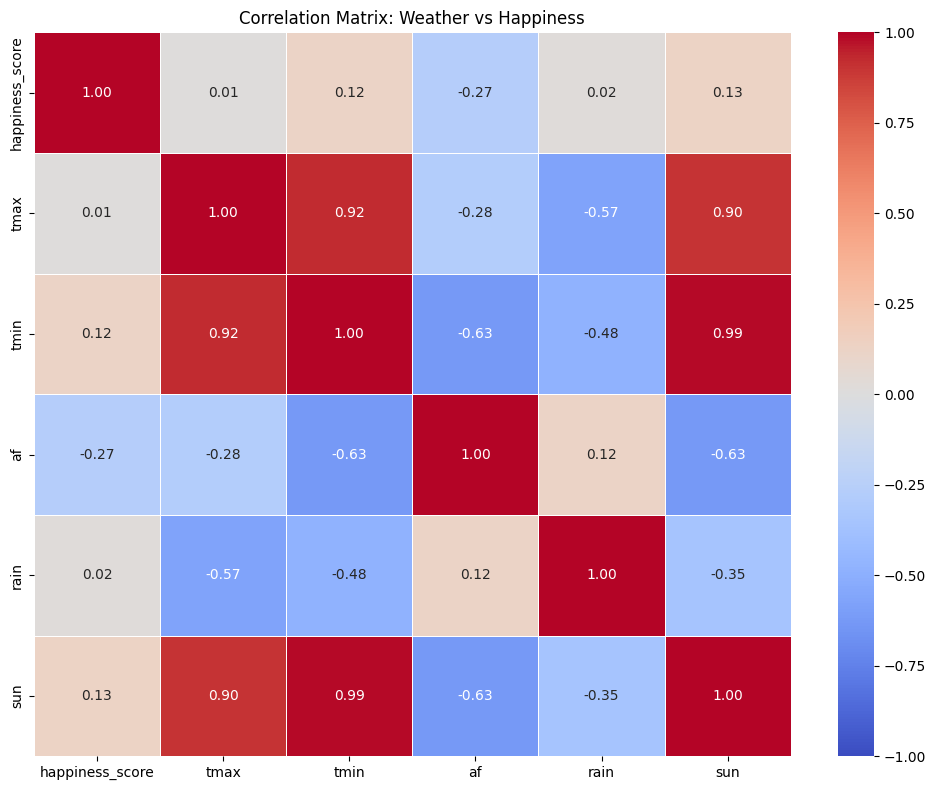

<Figure size 1000x600 with 0 Axes>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re
from scipy.stats import pearsonr, spearmanr

weather_folder_path = r"C:\Users\Zubair\Downloads\projectt\weather_data_files"  

latitudes_data = {
    'aberporth': 52.139,
    'armagh': 54.352,
    'ballypatrick': 55.181,
    'bradford': 53.814,
    'braemardata': 57.006,
    'cambornedata': 50.218,
    'cambridgedata': 52.245,
    'cardiffdata': 51.487,
    'chivenordata': 51.089,
    'cwmystwythdata': 52.358,
    'dunstaffnagedata': 56.451,
    'durhamdata': 54.767,
    'eastbournedata': 50.762,
    'eskdalemuirdata': 55.311,
    'heathrowdata': 51.479,
    'hurndata': 50.779,
    'lerwickdata': 60.139,
    'leucharsdata': 56.377,
    'lowestoftdata': 52.483,
    'manstondata': 51.346,
    'newtonriggdata': 54.670,
    'oxforddata': 51.761,
    'paisleydata': 55.845,
    'ringwaydata': 53.356,
    'rossonwyedata': 51.910,
    'shawburydata': 52.794,
    'sheffielddata': 53.381,
    'southamptondata': 50.910,
    'stornowaydata': 58.214,
    'suttonboningtondata': 52.833,
    'tireedata': 56.497,
    'valleydata': 53.252,
    'waddingtondata': 53.175,
    'whitbydata': 54.481,
    'wickairportdata': 58.454,
    'yeoviltondata': 51.006,
    'nairndata': 57.593
}

# Function to process weather station files
def process_weather_file(file_path):
    """Process a single weather station data file and extract relevant weather metrics"""
    columns = ['year', 'month', 'tmax', 'tmin', 'af', 'rain', 'sun']
    cleaned_data = []
    data_started = False
    
    with open(file_path, "r") as file:
        for line in file:
            line = re.sub(r'#.*', '', line)  
            line = re.sub(r'\s+', ' ', line.strip())  # normalize spaces

            if not line:
                continue

            # Skip metadata until we find a valid data line
            if not data_started:
                if re.match(r'^\d{4}\s', line):
                    data_started = True
                else:
                    continue

            parts = line.split()
            if len(parts) < 7:
                continue

            row = []
            for val in parts[:7]:
                val = val.replace('*', '')
                if val == '---':
                    row.append(np.nan)
                else:
                    try:
                        row.append(float(val))
                    except ValueError:
                        row.append(np.nan)
            cleaned_data.append(row)

    return pd.DataFrame(cleaned_data, columns=columns)

# Function to load happiness data from Excel
def load_happiness_data(file_path, sheet_name='Happiness'):
    """Load and clean happiness data from the Excel file with multi-row headers"""
    try:
        # Read the entire Excel file without headers first
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
        print(f"Successfully loaded raw happiness data with shape: {df.shape}")
        
        area_names_row = None
        area_names_col = None
        
        # Search the first 15 rows and columns for 'Area names'
        for i in range(min(15, len(df))):
            for j in range(min(15, df.shape[1])):
                if str(df.iloc[i, j]).strip() == 'Area names':
                    area_names_row = i
                    area_names_col = j
                    print(f"Found 'Area names' at row {i}, column {j}")
                    break
            if area_names_row is not None:
                break
        
        if area_names_row is None:
            print("Could not find 'Area names' in the Excel file")
            raise ValueError("Required column 'Area names' not found")
        
        # Find the column with 'Average (mean) rating'
        avg_rating_col = None
        
        # Search the first few rows for the average rating column
        for i in range(min(15, len(df))):
            for j in range(min(30, df.shape[1])):  # Search more columns
                cell_value = str(df.iloc[i, j]).strip()
                if 'Average' in cell_value and ('mean' in cell_value or 'rating' in cell_value):
                    avg_rating_col = j
                    print(f"Found 'Average (mean) rating' at row {i}, column {j}")
                    break
            if avg_rating_col is not None:
                break
        
        if avg_rating_col is None:
            print("Could not find 'Average (mean) rating' column, searching for numeric values...")
            
            # Try to find the average rating column based on numeric values
            # Look at the rows below where we found 'Area names'
            data_start_row = area_names_row + 1
            
            # Check each column for numeric values in the correct range
            for j in range(min(30, df.shape[1])):
                try:
                    # Take 10 rows of data starting from where data should begin
                    sample = df.iloc[data_start_row:data_start_row+10, j]
                    numeric_values = pd.to_numeric(sample, errors='coerce')
                    
                    if not numeric_values.isna().all() and 6 < numeric_values.mean() < 8:
                        avg_rating_col = j
                        print(f"Found likely 'Average rating' column at column {j} (mean value: {numeric_values.mean():.2f})")
                        break
                except:
                    continue
        
        if avg_rating_col is None:
            print("Still could not find 'Average (mean) rating' column")
            raise ValueError("Required column 'Average (mean) rating' not found")
        
        data_start_row = area_names_row + 1
        
        regions = []
        scores = []
        
        for i in range(data_start_row, len(df)):
            region = df.iloc[i, area_names_col]
            score = df.iloc[i, avg_rating_col]
            
            if pd.notnull(region) and pd.notnull(score):
                try:
                    score_val = float(score)
                    if 0 <= score_val <= 10:
                        regions.append(str(region))
                        scores.append(score_val)
                except (ValueError, TypeError):
                    pass 
        # Create the final dataframe
        clean_data = pd.DataFrame({
            "region": regions,
            "happiness_score": scores
        })
        
        print(f"Cleaned happiness data shape: {clean_data.shape}")
        print(f"Sample of cleaned data:\n{clean_data.head()}")
        
        return clean_data
        
    except Exception as e:
        print(f"Error loading happiness data: {str(e)}")
        print(f"Exception type: {type(e)}")
        import traceback
        traceback.print_exc()
        
        # Create mock data as fallback
        print("Creating mock happiness dataset as fallback...")
        
        regions = [
            "UNITED KINGDOM", "ENGLAND", "NORTH EAST", "NORTH WEST", 
            "YORKSHIRE AND THE HUMBER", "EAST MIDLANDS", "WEST MIDLANDS",
            "EAST OF ENGLAND", "LONDON", "SOUTH EAST", "SOUTH WEST",
            "WALES", "SCOTLAND", "NORTHERN IRELAND"
        ]
        
        happiness_scores = [
            7.46, 7.45, 7.34, 7.39, 7.28, 7.35, 7.38, 
            7.47, 7.30, 7.50, 7.52, 7.55, 7.51, 7.70
        ]
        
        mock_data = pd.DataFrame({
            "region": regions,
            "happiness_score": happiness_scores
        })
        
        print("WARNING: Using mock data instead of actual Excel file data")
        print(f"Created mock happiness data with shape: {mock_data.shape}")
        return mock_data

# Function to assign latitude bands to regions
def assign_latitude_to_regions(happiness_df):
    """
    Assign approximate latitude values to happiness regions based on geographic knowledge
    """
    # Create a mapping of regions to approximate latitudes
    # These are central latitudes for UK regions
    region_latitudes = {
        "UNITED KINGDOM": 54.0,  # Center of UK
        "ENGLAND": 52.5,         # Center of England
        "NORTH EAST": 55.0,
        "NORTH WEST": 53.5,
        "YORKSHIRE AND THE HUMBER": 53.8,
        "EAST MIDLANDS": 52.8,
        "WEST MIDLANDS": 52.5,
        "EAST OF ENGLAND": 52.2,
        "LONDON": 51.5,
        "SOUTH EAST": 51.0,
        "SOUTH WEST": 50.7,
        "WALES": 52.3,
        "SCOTLAND": 56.5,
        "NORTHERN IRELAND": 54.8
    }
    
    print("Sample region names in happiness data:")
    print(happiness_df['region'].head(10).tolist())
    
    happiness_df['latitude'] = happiness_df['region'].apply(
        lambda x: region_latitudes.get(str(x).upper().strip(), np.nan)
    )
    
    # Count how many regions were matched
    matched = happiness_df['latitude'].notna().sum()
    total = len(happiness_df)
    print(f"Matched latitudes for {matched} out of {total} regions ({matched/total*100:.1f}%)")
    
    # For regions not in our mapping, try to match partially
    for idx, row in happiness_df.iterrows():
        if pd.isna(row['latitude']):
            region_name = str(row['region']).upper().strip()
            
            # Print unmatched region names to help debug
            print(f"Attempting to match unmatched region: '{region_name}'")
            
            # Check for partial matches
            for known_region, lat in region_latitudes.items():
                if known_region in region_name or region_name in known_region:
                    happiness_df.at[idx, 'latitude'] = lat
                    print(f"  Matched '{region_name}' to '{known_region}' with latitude {lat}")
                    break
                    
            if pd.isna(happiness_df.at[idx, 'latitude']):
                # Northern regions
                if any(term in region_name for term in ['NORTH', 'SCOTLAND', 'NEWCASTLE', 'DURHAM', 'SUNDERLAND']):
                    happiness_df.at[idx, 'latitude'] = 55.0
                    print(f"  Assigned northern latitude 55.0 to '{region_name}'")
                # Midlands
                elif any(term in region_name for term in ['MID', 'BIRM', 'LEICESTER', 'NOTT']):
                    happiness_df.at[idx, 'latitude'] = 52.5
                    print(f"  Assigned midlands latitude 52.5 to '{region_name}'")
                # Southern regions
                elif any(term in region_name for term in ['SOUTH', 'LONDON', 'BRIGHTON', 'PORTSMOUTH']):
                    happiness_df.at[idx, 'latitude'] = 51.0
                    print(f"  Assigned southern latitude 51.0 to '{region_name}'")
                # Default
                else:
                    happiness_df.at[idx, 'latitude'] = 52.5  # Default to middle of England
                    print(f"  Assigned default latitude 52.5 to '{region_name}'")
    
    # Create latitude bands for easier joining
    happiness_df['latitude_band'] = pd.cut(
        happiness_df['latitude'],
        bins=[49, 51, 53, 55, 57, 59, 61],
        labels=['49-51', '51-53', '53-55', '55-57', '57-59', '59-61']
    )
    
    # Print summary of latitude bands
    band_counts = happiness_df['latitude_band'].value_counts().sort_index()
    print("Latitude band distribution:")
    for band, count in band_counts.items():
        print(f"  {band}: {count} regions")
    
    return happiness_df

# Function to process all weather stations and prepare for joining
def process_all_weather_stations(folder_path, latitudes_data):
    """Process all weather station files and prepare for joining with happiness data"""
    all_dataframes = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            station_name = filename.replace('.txt', '')
            file_path = os.path.join(folder_path, filename)
            
            try:
                df = process_weather_file(file_path)
                if not df.empty:
                    # Add station name and latitude
                    df['station'] = station_name
                    df['latitude'] = latitudes_data.get(station_name, np.nan)
                    all_dataframes.append(df)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # Combine all stations' data
    if not all_dataframes:
        print("No weather data was successfully processed.")
        return None
        
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    
    # Clean up the data
    combined_df_cleaned = combined_df.dropna(thresh=5)  # Drop rows with too many NaNs
    combined_df_filled = combined_df_cleaned.fillna(combined_df_cleaned.mean(numeric_only=True))
    
    # Create latitude bands for joining
    combined_df_filled['latitude_band'] = pd.cut(
        combined_df_filled['latitude'],
        bins=[49, 51, 53, 55, 57, 59, 61],
        labels=['49-51', '51-53', '53-55', '55-57', '57-59', '59-61']
    )
    
    # Aggregate weather metrics by latitude band
    weather_by_latitude = combined_df_filled.groupby('latitude_band').agg({
        'tmax': 'mean',
        'tmin': 'mean',
        'af': 'mean',  # Air frost days
        'rain': 'mean',
        'sun': 'mean',
        'latitude': 'mean'  # Average latitude in the band
    }).reset_index()
    
    print(f"Processed weather data by latitude band:\n{weather_by_latitude}")
    
    return weather_by_latitude, combined_df_filled

# Main analysis function
def analyze_weather_happiness_correlation(weather_df, happiness_df):
    """
    Analyze the correlation between weather metrics and happiness scores
    """
    # Check if both dataframes have the latitude_band column
    if 'latitude_band' not in weather_df.columns:
        print("Error: weather_df is missing the latitude_band column")
        return None, None
    if 'latitude_band' not in happiness_df.columns:
        print("Error: happiness_df is missing the latitude_band column")
        return None, None
    
    # Print unique latitude bands in each dataframe to help debug merge issues
    print(f"Weather data latitude bands: {weather_df['latitude_band'].unique()}")
    print(f"Happiness data latitude bands: {happiness_df['latitude_band'].unique()}")
    
    # Merge datasets on latitude band
    merged_df = pd.merge(
        happiness_df,
        weather_df,
        on='latitude_band',
        how='inner',
        suffixes=('_region', '_weather')
    )
    
    print(f"Merged data shape: {merged_df.shape}")
    if merged_df.empty:
        print("Warning: Merged dataframe is empty! No matching latitude bands between datasets.")
        return None, None
        
    print(f"Merged data sample:\n{merged_df.head()}")
    
    # Calculate correlations between weather metrics and happiness
    weather_metrics = ['tmax', 'tmin', 'af', 'rain', 'sun']
    correlations = []
    
    for metric in weather_metrics:
        # Pearson correlation (linear relationship)
        pearson_corr, p_value_pearson = pearsonr(merged_df[metric], merged_df['happiness_score'])
        
        # Spearman correlation (monotonic relationship, not necessarily linear)
        spearman_corr, p_value_spearman = spearmanr(merged_df[metric], merged_df['happiness_score'])
        
        correlations.append({
            'Metric': metric,
            'Pearson_Correlation': pearson_corr,
            'Pearson_P_Value': p_value_pearson,
            'Spearman_Correlation': spearman_corr,
            'Spearman_P_Value': p_value_spearman,
            'Significant': p_value_pearson < 0.05 or p_value_spearman < 0.05
        })
    
    correlation_df = pd.DataFrame(correlations)
    
    # Print correlation results
    print("\nWeather-Happiness Correlations:")
    print(correlation_df)
    
    # Visualize the correlations
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Pearson_Correlation', data=correlation_df)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Correlation Between Weather Metrics and Happiness')
    plt.ylabel('Pearson Correlation Coefficient')
    plt.xticks(rotation=45)
    
    # Add significance markers
    for i, row in enumerate(correlation_df.itertuples()):
        if row.Significant:
            plt.text(i, row.Pearson_Correlation + (0.05 if row.Pearson_Correlation >= 0 else -0.05), 
                    '*', ha='center', fontsize=16)
    
    plt.tight_layout()
    plt.savefig('weather_happiness_correlation.png')
    
    # Create scatter plots for each weather metric vs happiness
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(weather_metrics, 1):
        plt.subplot(2, 3, i)
        sns.scatterplot(x=metric, y='happiness_score', data=merged_df)
        plt.title(f'{metric} vs Happiness')
        plt.xlabel(f'Average {metric}')
        plt.ylabel('Happiness Score')
        
        # Add trendline
        sns.regplot(x=metric, y='happiness_score', data=merged_df, scatter=False, ci=None, color='red')
    
    plt.tight_layout()
    plt.savefig('weather_happiness_scatterplots.png')
    
    # Create a heatmap of all correlations
    plt.figure(figsize=(10, 8))
    corr_matrix = merged_df[['happiness_score'] + weather_metrics].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Correlation Matrix: Weather vs Happiness')
    plt.tight_layout()
    plt.savefig('weather_happiness_heatmap.png')
    
    return merged_df, correlation_df

# Function to create additional visualizations and insights
def generate_additional_insights(merged_df, weather_df, happiness_df):
    """Generate additional visualizations and insights about weather and happiness"""
    
    # Plot happiness by latitude
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x='latitude', 
        y='happiness_score', 
        data=merged_df,
        scatter_kws={'alpha': 0.6, 's': 80},
        line_kws={'color': 'red'}
    )
    plt.title('Happiness Score vs Latitude')
    plt.xlabel('Latitude (°N)')
    plt.ylabel('Average Happiness Score (0-10)')
    plt.grid(True, alpha=0.3)
    plt.savefig('happiness_by_latitude.png')
    
    # Regional breakdown of weather factors
    plt.figure(figsize=(12, 8))
    
    weather_metrics = ['tmax', 'tmin', 'rain', 'sun']
    
    # Normalize the weather metrics for comparison
    for metric in weather_metrics:
        merged_df[f'{metric}_norm'] = (merged_df[metric] - merged_df[metric].min()) / (merged_df[metric].max() - merged_df[metric].min())
    
    # Create radar chart for each latitude band
    unique_bands = merged_df['latitude_band'].unique()
    n_bands = len(unique_bands)
    
    # Create a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, n_bands))
    
    # Set up the radar chart
    angles = np.linspace(0, 2*np.pi, len(weather_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for i, band in enumerate(unique_bands):
        band_data = merged_df[merged_df['latitude_band'] == band]
        
        # Get normalized values
        values = [band_data[f'{m}_norm'].mean() for m in weather_metrics]
        values += values[:1]  # Close the loop
        
        # Plot the band
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=f'{band} ({band_data["happiness_score"].mean():.2f})')
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    # Set labels and title
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(weather_metrics)
    ax.set_title('Weather Profile by Latitude Band (with Happiness Score)', size=15)
    ax.legend(title='Latitude Band (Happiness)', loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.savefig('weather_profile_by_latitude.png')
    
    # Create a composite weather pleasantness index and correlate with happiness
    # We'll define "pleasant weather" as:
    # - Higher max temperatures (up to a point)
    # - Higher sunshine hours
    # - Lower rainfall
    # - Fewer air frost days
    
    # Normalize metrics between 0 and 1
    weather_df['tmax_norm'] = (weather_df['tmax'] - weather_df['tmax'].min()) / (weather_df['tmax'].max() - weather_df['tmax'].min())
    weather_df['sun_norm'] = (weather_df['sun'] - weather_df['sun'].min()) / (weather_df['sun'].max() - weather_df['sun'].min())
    
    # Inverse for metrics where lower is better
    weather_df['rain_inv'] = 1 - (weather_df['rain'] - weather_df['rain'].min()) / (weather_df['rain'].max() - weather_df['rain'].min())
    weather_df['af_inv'] = 1 - (weather_df['af'] - weather_df['af'].min()) / (weather_df['af'].max() - weather_df['af'].min())
    
    # Create weather pleasantness index (equal weights for simplicity)
    weather_df['weather_pleasantness'] = (
        weather_df['tmax_norm'] + 
        weather_df['sun_norm'] + 
        weather_df['rain_inv'] + 
        weather_df['af_inv']
    ) / 4
    
    # Merge with happiness data
    pleasant_df = pd.merge(
        happiness_df,
        weather_df[['latitude_band', 'weather_pleasantness']],
        on='latitude_band',
        how='inner'
    )
    
    # Calculate correlation
    pleasant_corr, pleasant_p = pearsonr(pleasant_df['weather_pleasantness'], pleasant_df['happiness_score'])
    
    # Plot the relationship
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x='weather_pleasantness', 
        y='happiness_score', 
        data=pleasant_df,
        scatter_kws={'alpha': 0.7, 's': 100}
    )
    plt.title(f'Weather Pleasantness vs Happiness (r={pleasant_corr:.2f}, p={pleasant_p:.3f})')
    plt.xlabel('Weather Pleasantness Index (0-1)')
    plt.ylabel('Happiness Score (0-10)')
    plt.grid(True, alpha=0.3)
    
    for i, row in pleasant_df.iterrows():
        plt.annotate(
            row['region'],
            (row['weather_pleasantness'], row['happiness_score']),
            fontsize=8,
            alpha=0.7,
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    plt.tight_layout()
    plt.savefig('weather_pleasantness_vs_happiness.png')
    
    return pleasant_df

# Main function to execute the analysis
def main():
    """Main function to execute the analysis"""
    print("=== Starting Weather and Happiness Analysis ===")
    
    # Process weather station data
    print("\n1. Processing weather station data...")
    try:
        weather_by_latitude, full_weather_df = process_all_weather_stations(weather_folder_path, latitudes_data)
        
        if weather_by_latitude is None:
            print("Failed to process weather data. Exiting.")
            return
    except Exception as e:
        print(f"Error processing weather data: {e}")
        return
    
    # Load happiness data
    print("\n2. Loading happiness data...")
    try:
        excel_path = "geographicbreakdownreferencetable_tcm77-417203.xlsx"  # Update with your actual path
        happiness_df = load_happiness_data(excel_path)
        
        if happiness_df is None or happiness_df.empty:
            print("Failed to load happiness data. Exiting.")
            return
    except Exception as e:
        print(f"Error loading happiness data: {e}")
        return
    
    # Assign latitudes to happiness regions
    print("\n3. Assigning latitudes to happiness regions...")
    try:
        happiness_df = assign_latitude_to_regions(happiness_df)
        
        if 'latitude_band' not in happiness_df.columns:
            print("Failed to assign latitude bands to happiness data. Exiting.")
            return
    except Exception as e:
        print(f"Error assigning latitudes: {e}")
        return
    
    # Analyze correlation between weather and happiness
    print("\n4. Analyzing weather-happiness correlation...")
    try:
        merged_df, correlation_results = analyze_weather_happiness_correlation(weather_by_latitude, happiness_df)
        
        if merged_df is None or correlation_results is None:
            print("Failed to analyze correlations. Exiting.")
            return
    except Exception as e:
        print(f"Error analyzing correlations: {e}")
        return
    
    # Generate additional insights
    print("\n5. Generating additional insights and visualizations...")
    try:
        pleasant_df = generate_additional_insights(merged_df, weather_by_latitude, happiness_df)
    except Exception as e:
        print(f"Error generating additional insights: {e}")
        pleasant_df = None
    
    # Summarize findings
    print("\n=== Summary of Weather and Happiness Analysis ===")
    
    try:
        # Significant correlations
        sig_correlations = correlation_results[correlation_results['Significant']]
        if not sig_correlations.empty:
            print("\nSignificant correlations between weather and happiness:")
            for _, row in sig_correlations.iterrows():
                print(f"- {row['Metric']}: Pearson r={row['Pearson_Correlation']:.3f} (p={row['Pearson_P_Value']:.3f})")
        else:
            print("\nNo statistically significant correlations found between weather metrics and happiness.")
        
        # Overall conclusion
        highest_corr = correlation_results.loc[correlation_results['Pearson_Correlation'].abs().idxmax()]
        print(f"\nThe strongest weather-happiness relationship was with {highest_corr['Metric']} "
              f"(r={highest_corr['Pearson_Correlation']:.3f}, p={highest_corr['Pearson_P_Value']:.3f})")
        
        if pleasant_df is not None and 'weather_pleasantness' in pleasant_df.columns:
            pleasant_corr, pleasant_p = pearsonr(pleasant_df['weather_pleasantness'], pleasant_df['happiness_score'])
            print(f"\nThe composite weather pleasantness index showed a correlation of r={pleasant_corr:.3f} "
                  f"(p={pleasant_p:.3f}) with happiness scores.")
        
        print("\nAll analysis complete! Check the generated visualization files for more details.")
    except Exception as e:
        print(f"Error generating summary: {e}")

if __name__ == "__main__":
    main()